In [1]:
import timeit
import psutil
import sys
import os
import matplotlib.pyplot as plt

from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor as Pool

In [2]:
os.chdir('../../../')
sys.path.append(os.getcwd())


from Algorithms.python_solutions.merge_sort import merge_sort
from Algorithms.python_solutions.count_sort import count_sort
from Algorithms.python_solutions.digit_sort import digit_sort, digit_sort_opt
from Algorithms.python_solutions.tests.test_sorts_and_searches import whole_1_dim_array

In [3]:
def measure_runtime_and_memory(func, params, array):
    memory_before = psutil.virtual_memory()[3] / 1024 # in KB
    start_time = timeit.default_timer()
    func(array, **params)
    end_time = timeit.default_timer()
    memory_after = psutil.virtual_memory()[3] / 1024
    memory_usage = memory_after - memory_before
    runtime = end_time - start_time
    return runtime, memory_usage

In [4]:
def run_tests_int(sort_functions, funcs_params, input_sizes, input_range,
                    executor=Pool):
    data = {label: [] for _, label in sort_functions}
    with executor(max_workers=cpu_count()) as pool:
        for sort_func, label in sort_functions:
            for size in input_sizes:
                array = whole_1_dim_array(
                    elts_range=input_range, size_of_1_dim_range=size)
                data[label].append(pool.submit(
                    measure_runtime_and_memory, sort_func,
                    funcs_params[str(sort_func.__name__)],
                    array))
        for sort_func, label in sort_functions:
            for i in range(len(data[label])):
                data[label][i] = data[label][i].result()
    return data

In [5]:
def plot_results(data_to_plot):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    for label in data_to_plot:
        ax1.plot([i[0] for i in input_sizes], [sum([runtime for runtime, memory in i])/len([runtime for runtime, memory in i]) \
                                           for i in data_to_plot[label]], marker='o', label=f'{label} (Runtime)')
        ax2.plot([i[0] for i in input_sizes], [sum([memory for runtime, memory in i])/len([memory for runtime, memory in i]) \
                                           for i in data_to_plot[label]], marker='x', label=f'{label} (Memory)')

    ax1.set_xlabel('Input Size')
    ax1.set_ylabel('Runtime (seconds)')
    ax2.set_ylabel('Memory (KB)')
    #ax1.set_xscale('log')
    #ax2.set_xscale('log')
    fig.legend(loc='upper right')
    plt.grid(True)
    plt.title('Sorting Algorithms Runtimes and Memory Consumption')
    plt.show()

Let's try some sorts of integers, compare them to others and optimize them. We will start the same way as with sorts for float numbers.

Now, for many described sorts an input of the array **has** an influence on the time complexity not only in terms of the size of the array but more in terms of number ranges. We will compare them with the merge sort algorithm and run them all on different inputs.

In [6]:
input_sizes = [(1, 1), (5, 5), (10, 10), (50, 50), (100, 100), (500, 500), (1000, 1000)]

sorting_algorithms = [
    (count_sort, 'Count Sort'),
    (digit_sort, 'Digit Sort'),
    (digit_sort_opt, 'Digit Sort Opt'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'count_sort': {},
    'digit_sort': {},
    'merge_sort': {},
    'digit_sort_opt': {}
}

input_range = (-100, 100)

In [7]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_int(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

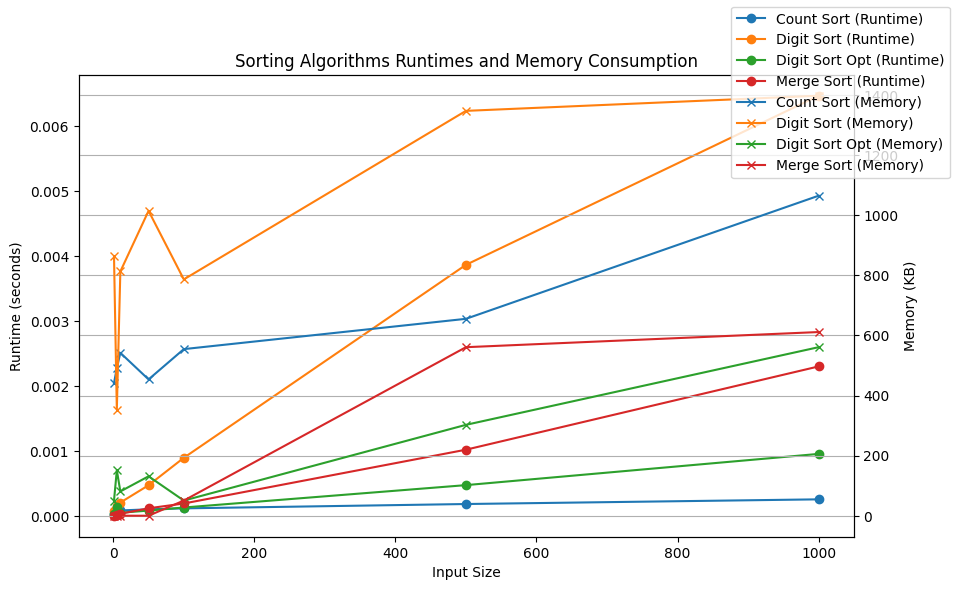

In [8]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

There are 2 different digit sorts imported. One (unoptimized) utilizes more bold approach: extracts digits from numbers, places them into arrays, adds (-inf)s in the front of the arrays, so that they would make a rectangular 2-dim matrix, and then sorts using a counting sort. The second one utilizes a radix sort approach with buckets.

Now, let's increase the input size.

In [9]:
input_sizes = [(5000, 5000), (10000, 10000), (50000, 50000), (100000, 100000), (500000, 500000)]

sorting_algorithms = [
    (count_sort, 'Count Sort'),
    (digit_sort, 'Digit Sort'),
    (digit_sort_opt, 'Digit Sort Opt'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'count_sort': {},
    'digit_sort': {},
    'merge_sort': {},
    'digit_sort_opt': {}
}

In [10]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_int(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

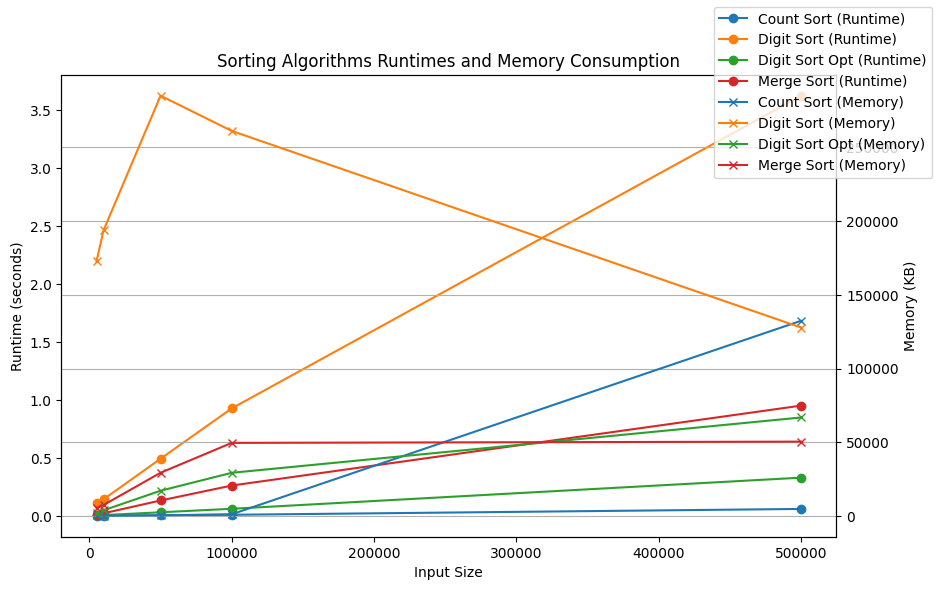

In [11]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

For time considerations, only an optimized version would be considered. Let's increase input even further!

In [12]:
input_sizes = [(1000000, 1000000), (5000000, 5000000), (10000000, 10000000)]

sorting_algorithms = [
    (count_sort, 'Count Sort'),
    (digit_sort_opt, 'Digit Sort Opt'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'count_sort': {},
    'digit_sort_opt': {},
    'merge_sort': {}
}

In [13]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_int(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

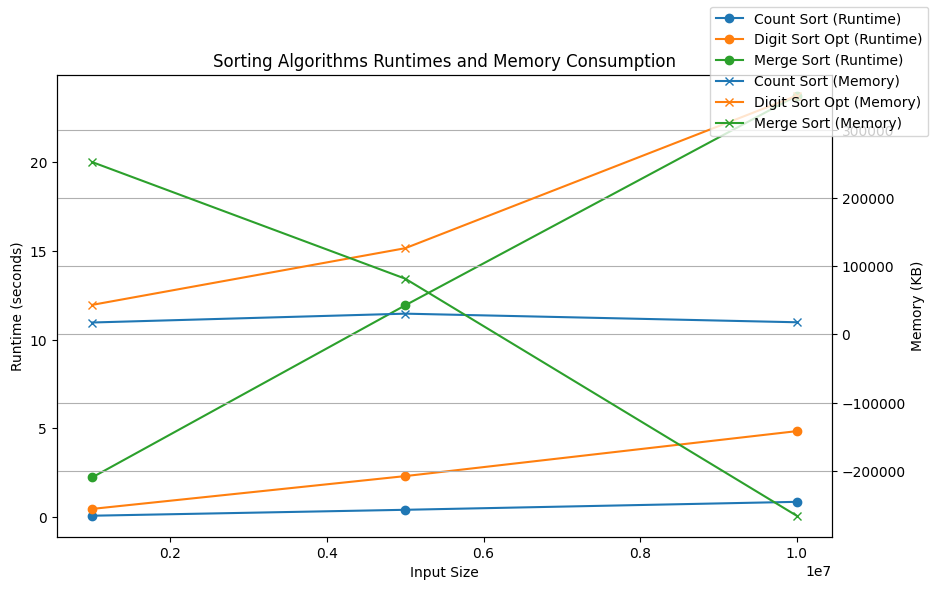

In [14]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

We already see merge sort being outperformed by digit sort and count sort. However, they have their own weaknesses: for unoptimised digit sort - a lot of digits, for count sort - big range of numbers. Let's start from small arrays and expoit those weaknesses.

In [15]:
input_sizes = [(1, 1), (5, 5), (10, 10), (50, 50), (100, 100), (500, 500), (1000, 1000)]

sorting_algorithms = [
    (count_sort, 'Count Sort'),
    (digit_sort_opt, 'Digit Sort Opt'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'count_sort': {},
    'merge_sort': {},
    'digit_sort_opt': {}
}

# Here is a large range
input_range = (-1000000, 1000000)

In [16]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_int(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

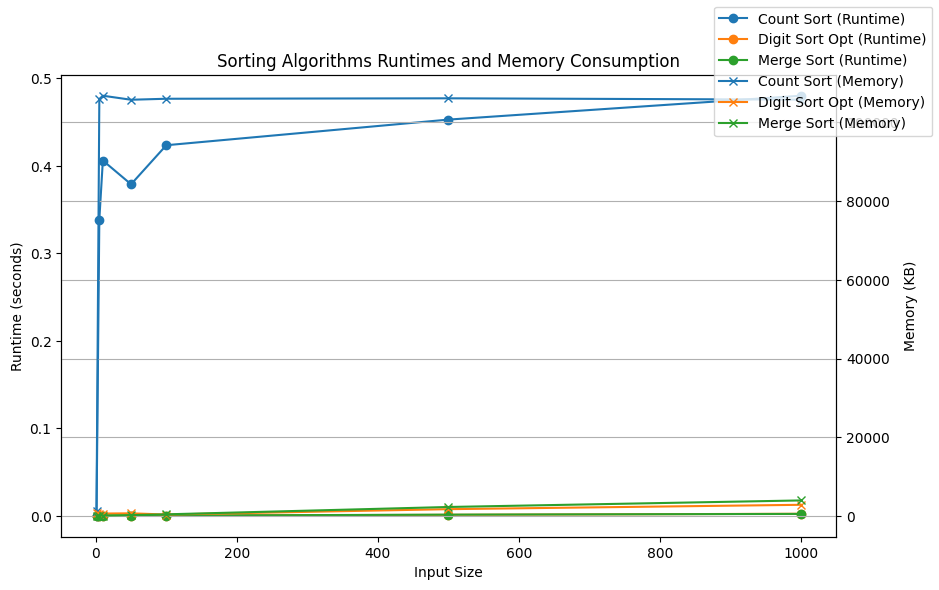

In [17]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

There is the expoited weakness of count sort, let's now exploit the digit sort weakness

In [21]:
input_sizes = [(1, 1), (5, 5), (10, 10), (50, 50), (100, 100), (500, 500), (1000, 1000)]

sorting_algorithms = [
    (count_sort, 'Count Sort'),
    (digit_sort, 'Digit Sort'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'count_sort': {},
    'merge_sort': {},
    'digit_sort': {}
}

# Not a large range, but big numbers
input_range = (10000000, 10000100)

In [22]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_int(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

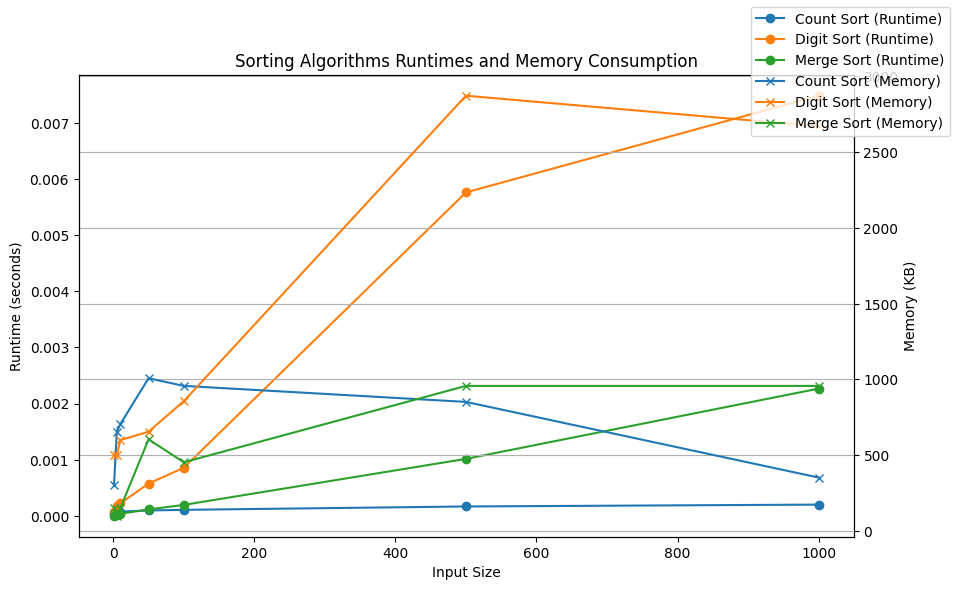

In [23]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

Weakness to digits comes only for unoptimized sort, and the nature of this weakness comes from count sort legacy.

The optimized implementation does not have such weakness:

In [24]:
input_sizes = [(1, 1), (5, 5), (10, 10), (50, 50), (100, 100), (500, 500), (1000, 1000)]

sorting_algorithms = [
    (count_sort, 'Count Sort'),
    (digit_sort_opt, 'Digit Sort Opt'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'count_sort': {},
    'merge_sort': {},
    'digit_sort_opt': {}
}

input_range = (1000000000, 1000000100)

In [25]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_int(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

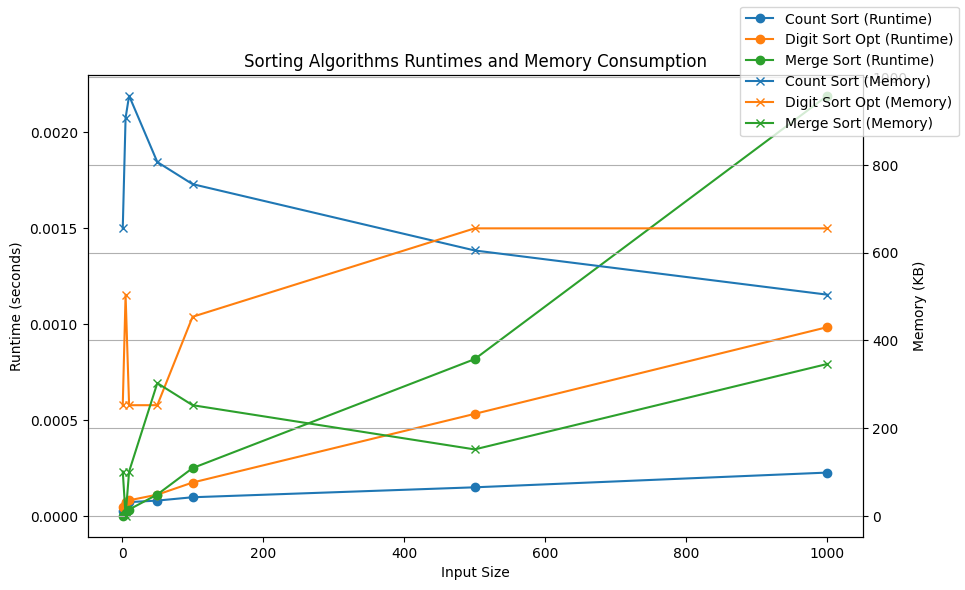

In [26]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

We see that unless their weaknesses are expoiled, integer sorts perform well even compared to merge sort.